In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import cross_val_score
import datetime

import matplotlib
from matplotlib import pyplot as plt

import torch
from torch import nn

def forma(x):
    x = [float(i.replace(',','.')) for i in  x.values]
    return x

def scale(x):
    x_mean = np.mean(x)
    x_std  = np.std(x)
    x_scaled = (x - x_mean)/x_std
    return x_scaled

def norm_scale(x):
    min = np.min(x)
    max = np.max(x)
    x_scaled = (x - min) / (max - min)
    return x_scaled

In [66]:
df = pd.read_csv('/content/Compare_ACE_DSCOVR.csv', sep=';')

df['B_x'] = df.shift(periods=21, fill_value=np.nan)['B_x']
df['B_gsm_y'] = df.shift(periods=11, fill_value=np.nan)['B_gsm_y']
df['B_gsm_z'] = df.shift(periods=3, fill_value=np.nan)['B_gsm_z']
df['B_magn'] = df.shift(periods=14, fill_value=np.nan)['B_magn']
df['H_den_SWP'] = df.shift(periods=10, fill_value=np.nan)['H_den_SWP']
df['SW_spd'] = df.shift(periods=55, fill_value=np.nan)['SW_spd']

values = ['B_x', 'B_gsm_y', 'B_gsm_z', 'B_magn', 'H_den_SWP', 'SW_spd']

for elem in values:
    df = df.drop(df[df[elem] == 'N'].index)
    df = df.dropna()

df_dst = df['Dst']

for elem in values:
    data = forma(df[elem])
    df[elem] = data

for elem in values:
    data = norm_scale(df[elem])
    df[elem] = data

In [109]:
date_values = ['year', 'month', 'day', 'hour from']
date = pd.DataFrame(df.loc[:, date_values])

date['hour from'] = date['hour from'].map(lambda x: '0'+str(x) if x not in range(10, 24) else str(x))
date['datetime'] = date['year'].astype(str) + date['month'].astype(str) + date['day'].astype(str) + ' ' + date['hour from']
date['datetime'] = pd.to_datetime(date['datetime'])

dataset = pd.DataFrame({elem:df[elem] for elem in values})
dataset = dataset.set_index(date['datetime'])

df_dst.index = date['datetime']

print(dataset)

                          B_x   B_gsm_y   B_gsm_z    B_magn  H_den_SWP  \
datetime                                                                 
1997-10-23 07:00:00  0.605616  0.450447  0.606314  0.059275   0.885741   
1997-10-23 08:00:00  0.625638  0.406819  0.594556  0.075702   0.885923   
1997-10-23 09:00:00  0.630441  0.413044  0.602145  0.085450   0.885194   
1997-10-23 10:00:00  0.626846  0.406738  0.626928  0.072025   0.885242   
1997-10-23 11:00:00  0.583198  0.395393  0.585975  0.071190   0.886284   
...                       ...       ...       ...       ...        ...   
2021-03-24 19:00:00  0.551385  0.482919  0.590318  0.081817   0.881612   
2021-03-24 20:00:00  0.562307  0.475862  0.594752  0.078932   0.883602   
2021-03-24 21:00:00  0.567260  0.467100  0.598230  0.082076   0.885622   
2021-03-24 22:00:00  0.574466  0.448702  0.544974  0.081759   0.885968   
2021-03-24 23:00:00  0.580935  0.447079  0.553792  0.072517   0.886908   

                       SW_spd  
datet

In [110]:
x_train = df_dst[:'2019-01-01 01:00:00'].to_numpy()
x_test = df_dst['2019-01-01 01:00:00':].to_numpy()
y_train = dataset.loc[:'2019-01-01 01:00:00'].to_numpy()
y_test = dataset.loc['2019-01-01 01:00:00':].to_numpy()

x_train= x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

model = linear_model.LinearRegression()
model.fit(x_train, y_train)
print('Coefficients:', model.coef_)
print('Intercept', model.intercept_)
print()

y_pred = model.predict(x_test)

print('R**2 score:', metrics.r2_score(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

# Calculation of R2 Score
print('R**2 score (cross val):', cross_val_score(model, dataset, df_dst, cv=10, scoring="r2").mean())  # почему r2 отличаются

Coefficients: [[ 1.71739582e-05]
 [-1.09203307e-04]
 [ 5.25827301e-04]
 [-1.27064314e-03]
 [-2.58116338e-05]
 [-3.51082467e-04]]
Intercept [0.58657005 0.44025435 0.5942749  0.0806623  0.88190207 0.65059674]

R**2 score: -0.04147181711406556
MSE: 0.0012719560081508243
MAE: 0.023596147035965603
R**2 score (cross val): 0.3638167600139973


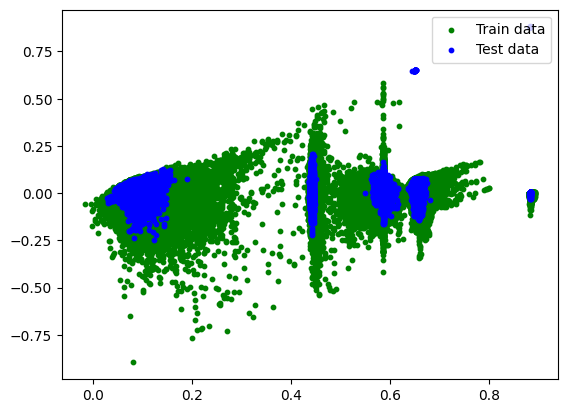

In [111]:
# plotting residual errors in training data
plt.scatter(model.predict(x_train),
            model.predict(x_train) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(y_pred, y_pred - y_test,
            color="blue", s=10,
            label='Test data')

plt.legend(loc='upper right')
plt.show()